In [2]:
import pandas as pd
import statsmodels as st
import matplotlib.pyplot as plt
import numpy as np

In [3]:
CustomerData = pd.read_excel('datasets/test3.xlsx')

In [14]:
CustomerData.head()

,month,LOB,patner type,product category,Sale type,deal size,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
0,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.140000,0.285679,0.00,0.000,0.0,0.0
1,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.125005,0.186930,56.04,102.495,173.2,0.0
2,2015-M10,CSB,V,XYZ 11,APOS,Small,1,0.075005,0.184192,0.00,0.000,0.0,0.0
3,2015-M10,CSB,V,XYZ 11,POS,Small,1,0.000000,0.183198,30.09,47.495,63.0,0.0
4,2015-M10,CSB,V,XYZ 11,POS,Small,1,0.000000,0.171554,0.00,0.000,0.0,0.0


In [15]:
CustomerData.describe()

/home/tivo/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
count,40204.000000,4.019200e+04,4.019200e+04,40204.000000,40204.000000,40204.000000,40204.000000
mean,2.864839,2.626222e+09,2.976385e+09,56.822743,193.508829,212.947811,0.074947
std,5.379440,5.265035e+11,5.967040e+11,74.338355,298.988724,339.290674,0.222483
min,1.000000,-7.733614e+01,-3.588307e+00,0.000000,0.000000,0.000000,0.000000
25%,1.000000,NaN,NaN,11.600000,37.495000,0.000000,0.000000
50%,1.000000,NaN,NaN,41.295000,102.495000,130.400000,0.000000
75%,2.000000,NaN,NaN,73.220000,242.495000,267.360000,0.000000
max,115.000000,1.055531e+14,1.196269e+14,929.525000,4004.995000,4830.210000,1.080000


In [16]:
CustomerData.corr()

,order qty,Discount,list margin,List revenue,cost price,selling price,cmp price
order qty,1.000000,-0.000802,-0.000802,-0.053086,-0.079325,-0.056973,-0.069551
Discount,-0.000802,1.000000,1.000000,-0.003814,-0.003229,-0.003132,-0.001680
list margin,-0.000802,1.000000,1.000000,-0.003814,-0.003229,-0.003132,-0.001680
List revenue,-0.053086,-0.003814,-0.003814,1.000000,0.947201,0.915462,0.120854
cost price,-0.079325,-0.003229,-0.003229,0.947201,1.000000,0.915316,0.241674
selling price,-0.056973,-0.003132,-0.003132,0.915462,0.915316,1.000000,0.152687
cmp price,-0.069551,-0.001680,-0.001680,0.120854,0.241674,0.152687,1.000000


In [18]:
CustomerData.columns

Index(['month', 'LOB', 'patner type', 'product category ', 'Sale type',
       'deal size', 'order qty', 'Discount', 'list margin', 'List revenue',
       'cost price ', 'selling price', 'cmp price'],
      dtype='object')

In [19]:
CustomerData['patner type'].unique()

array(['V', 'D', 'Direct'], dtype=object)

In [21]:
CustomerData['product category '].unique()

array(['XYZ 11', 'XYZ Others', 'XYZ 22', 'Client Others'], dtype=object)

In [125]:
#Check missing values
#CustomerData[CustomerData['Discount'] != 'NaN'] 

#As of now remove missing values # treatment if required, let's do later
CustomerDataTemp = CustomerData[pd.isnull(CustomerData['Discount']) == False]
    

In [66]:
def getUpperAndLowerOutlierThreshold(data):
    q75, q25 = np.percentile(data, [75 ,25])
    iqr = q75 - q25
    upperOutlier = q75 + iqr*1.5
    lowerOutlier = q25 - iqr*1.5
    return upperOutlier,lowerOutlier

In [67]:
# Let's select features
categoricalFeatures = ['product category ', 'patner type',  'Sale type','deal size']
numericfeatures = ['order qty', 'Discount']

In [68]:
for i in numericfeatures:
    upperOutlier,lowerOutlier = getUpperAndLowerOutlierThreshold(CustomerDataTemp[i])
    print("="*80)
    print (upperOutlier,lowerOutlier)
    print (i)
    
    totalLen = CustomerDataTemp.shape[0]
    afterRemovingOutliers = (CustomerDataTemp[((CustomerDataTemp[i] < upperOutlier) & 
                                           (CustomerDataTemp[i] > lowerOutlier ))].shape)[0]
    percentageOfOutliers = ( (totalLen - afterRemovingOutliers) / totalLen)*100
    print ("Total={}  #Outlier={} Outliers={} %".format(totalLen,totalLen - afterRemovingOutliers,percentageOfOutliers))
    print ()
    #Remove outliers

def removeOutliers(data,i):
    _upperOutlier,_lowerOutlier = getUpperAndLowerOutlierThreshold(data[i])
    return data[((data[i] < _upperOutlier) & (data[i] > _lowerOutlier ))]

print (CustomerDataTemp.shape)
CustomerDataRemovedMissingAndOL = removeOutliers(CustomerDataTemp,'Discount')
print (CustomerDataRemovedMissingAndOL.shape)

3.5 -0.5
order qty
Total=40192  #Outlier=6862 Outliers=17.073049363057326 %

0.369356601222 -0.061609896064
Discount
Total=40192  #Outlier=846 Outliers=2.104896496815287 %

(40192, 13)
(39346, 13)


# Outlier analysis indicates presence of few clusters
* Removing outliers s not good idea.
* Let's see if removing high influential points help

In [129]:
# GEt highest value
_a = CustomerDataTemp.sort(['Discount'],ascending=False)['Discount'].head(1).values[0]
_b = CustomerDataTemp.sort(['Discount'],ascending=True)['Discount'].head(3).values
# Remove it : it is too high
print (_a,_b)
CustomerDataTemp = CustomerDataTemp[CustomerDataTemp['Discount'] != _a]
CustomerDataTemp = CustomerDataTemp[-CustomerDataTemp['Discount'].isin(_b)]

1.05553116266e+14 [-77.33614064 -19.86520365 -10.91591656]


/home/tivo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app
/home/tivo/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


In [130]:
%matplotlib inline

count    40188.000000
mean         0.154828
std          0.107997
min         -4.800000
25%          0.100003
50%          0.140002
75%          0.207744
max          6.400000
Name: Discount, dtype: float64


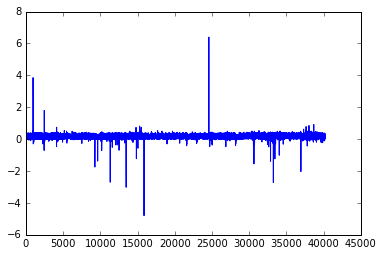

In [131]:
print (CustomerDataTemp['Discount'].describe())
#plt.plot(CustomerDataTemp['Discount'])
plt.plot(CustomerDataTemp['Discount'])

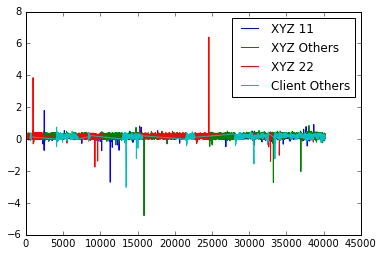

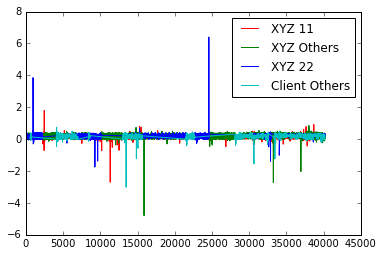

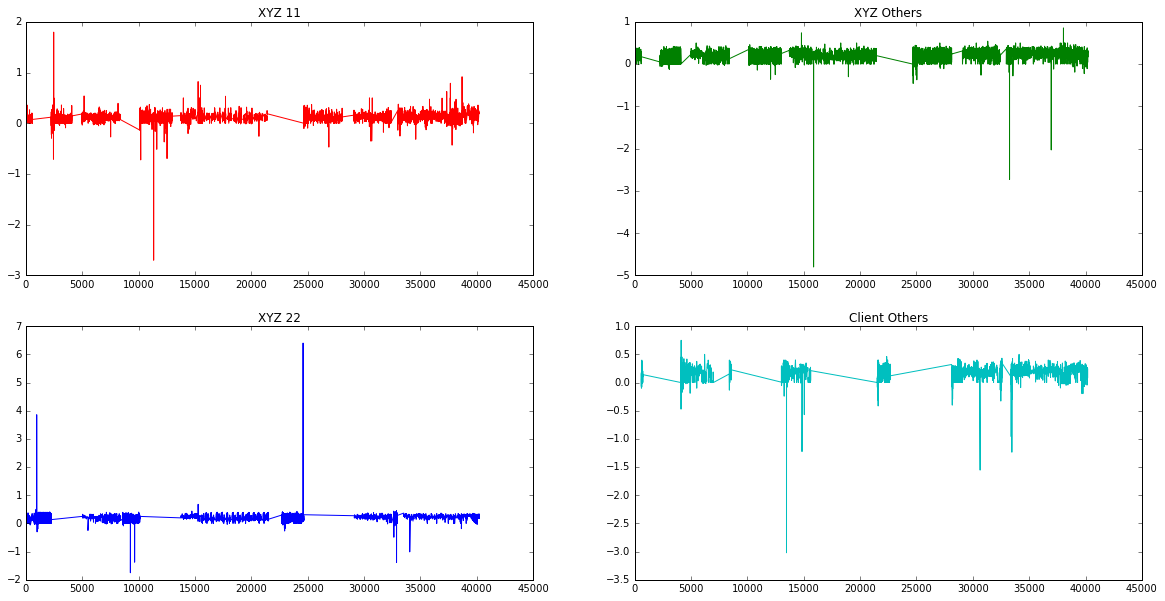

In [151]:
plt_legend = []
colormap='rgbc'
for index,val in enumerate(CustomerDataTemp['product category '].unique()):
    plt.plot(CustomerDataTemp[CustomerDataTemp['product category '] == val]['Discount'], color=colormap[index])
    plt_legend.append(val)
    
plt.legend(plt_legend)

f,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(20, 10))
axis = [ax1, ax2, ax3, ax4]
prodCategoryDescribe = pd.DataFrame(columns=['Product Category','min','max','mean','count'])
for index,val in enumerate(CustomerDataTemp['product category '].unique()):
    #print (index,val)
    prodCategory = CustomerDataTemp[CustomerDataTemp['product category '] == val]['Discount']
    axis[index].plot(prodCategory, color=colormap[index])
    axis[index].set_title(val)
    _prodDes = prodCategory.describe()
    prodCategoryDescribe.loc[index] = [val,_prodDes['min'], _prodDes['max'],_prodDes['mean'],_prodDes['count']]

In [152]:
prodCategoryDescribe

,Product Category,min,max,mean,count
0,XYZ 11,-2.699969,1.796064,0.109671,11185.0
1,XYZ Others,-4.800000,0.854450,0.196056,13406.0
2,XYZ 22,-1.749969,6.400000,0.162654,9726.0
3,Client Others,-3.019996,0.749469,0.133754,5871.0


          order qty      Discount   list margin  List revenue   cost price   \
count  39346.000000  39346.000000  39346.000000  39346.000000  39346.000000   
mean       2.885528      0.152529      0.307098     57.074662    193.240487   
std        5.422813      0.083776      0.087967     74.636439    299.410689   
min        1.000000     -0.060217     -1.579661      0.000000      0.000000   
25%        1.000000      0.100002      0.226201     11.600000     37.495000   
50%        1.000000      0.139989      0.331141     41.295000    102.495000   
75%        2.000000      0.201038      0.378899     73.220000    242.495000   
max      115.000000      0.369323      1.100000    929.525000   4004.995000   

       selling price     cmp price  
count   39346.000000  39346.000000  
mean      213.372959      0.072797  
std       340.697913      0.220393  
min         0.000000      0.000000  
25%         0.000000      0.000000  
50%       130.400000      0.000000  
75%       267.360000      0.0

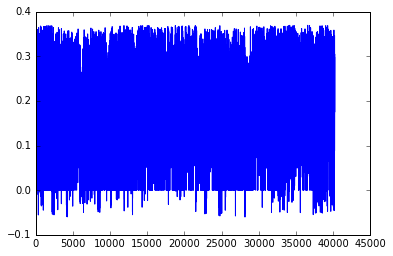

In [85]:
print (CustomerDataRemovedMissingAndOL.describe())
plt.plot(CustomerDataRemovedMissingAndOL['Discount'])

{'boxes': [<matplotlib.lines.Line2D at 0x7f94fab5c2b0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f94fab3bcc0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f94fb0f9e48>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f94fb0f9630>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f94fab5cc50>,
  <matplotlib.lines.Line2D at 0x7f94fab5cd68>]}

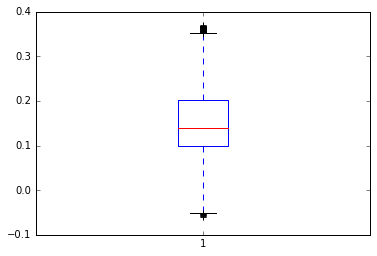

In [74]:
plt.boxplot(CustomerDataRemovedMissingAndOL['Discount'])

In [75]:
import numpy as np
from scipy import cluster
from matplotlib import pyplot

        month  LOB patner type product category  Sale type deal size  \
590  2015-M10  CSB           V     Client Others       POS     Small   
591  2015-M11  CSB           D     Client Others      APOS     Small   
592  2015-M11  CSB           D     Client Others       POS       big   
593  2015-M11  CSB           V     Client Others      APOS     Small   
594  2015-M12  CSB           V     Client Others      APOS     Small   

     order qty  Discount  list margin  List revenue  cost price   \
590          1  0.150030     0.348266          0.00        0.000   
591          1 -0.070298     0.311406         53.81      139.995   
592          2  0.175311     0.302105         56.43      139.995   
593          2 -0.088604     0.300882         53.81      139.995   
594          1  0.000012     0.285113         56.43      139.995   

     selling price  cmp price  
590          0.000        0.0  
591        228.645        0.0  
592        228.645        0.0  
593        228.645        0.0 

/home/tivo/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


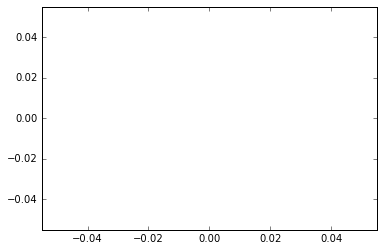

In [84]:

groups = CustomerDataTemp.groupby('product category ')

# Plot
fig, ax = plt.subplots()
#print (groups.head())
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    print (group.head(5))
    #ax.plot(group['patner type'], group['Discount'], marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()
#plt.scatter(CustomerDataTemp['Discount'])